# PyTorch for CIFAR10
We test ResNet classifier.
First init some basic environment.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

# resnet20 classifier

In [2]:
import numpy as np

In [3]:
import torch.optim as optim
import torch.nn as nn
import time
import sys
sys.path.append("cifar10/")

from cifar10.tnt_solver import *
from cifar10.classifiers.resnet import resnet14, resnet20
import copy

torch.manual_seed(6666)
torch.cuda.manual_seed(6666)

model_orig = resnet20()
print(model_orig)

_ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): _BasicBlock(
      (conv_bn_relu1): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv_bn2): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu_out): ReLU(inplace=True)
    )
    (1): _BasicBlock(
      (conv_bn_relu1): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, mom

In [4]:
print('num param = ', sum([len(param.flatten()) for param in model_orig.parameters()]))

num param =  272474


In [5]:
data = CIFAR10Data(train_split=0.8)
train_itr = data.get_train_loader(batch_size=64)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [124]:
def train_network(train_dl, val_dl, modelname, network, epochs, calc_every_x_epoch=10, device='cpu', pruned_weights=0, **kwargs):
    
    print('calc_every_x_epoch',calc_every_x_epoch)
        
    opt = optim.SGD(network.parameters(), lr=1e-1, momentum=0.9, weight_decay=1e-4, nesterov=False)
        
    loss_func = F.cross_entropy

    lr_scheduler= optim.lr_scheduler.MultiStepLR(opt, milestones=[91, 137], gamma=0.1)

#     history = main(model_orig, opt, epoch=5, model_name='ResNet20', pruned_weights=p_w, zero_masks=zero_masks, loss_fn=loss_fn, dev='cuda:1', lr_scheduler=lr_scheduler)

    training_information = pd.DataFrame({
                                    'modelname':[],
                                    'epoch':[],
                                    'loss_mb':[],
                                    'acc_mb':[],
                                    'loss':[],
                                    'acc':[],
#                                     'grad_norm_squared':[],
                                    'full_grad_norm':[],
                                    'pruned_weights':[]
                                    })

    
    opt.zero_grad()

    acc = 0
    loss = 0
    with torch.no_grad():
        for xb, yb in train_dl:
            xb = xb.to(device)
#             print(xb.device)
#             print(network.device)
            yb = yb.to(device)
            acc += accuracy(network(xb), yb)*len(yb)
            loss += loss_func(network(xb), yb)
        acc = acc/1000
        
    print('Epoch: 0 \t loss= %10.3e' %loss)
    
    print(p_w)
    if p_w > 0:
        zero_masks = []
        
        num_pos_param = sum([len(param[torch.abs(param)>0].flatten()) for param in network.parameters()])
        print(f'Num non-zero params before = {num_pos_param}')
        for param in network.parameters():

            param.requires_grad = False
            num_param = param.numel()

            num_zero_out = int(p_w*num_param)
            param_flt = param.flatten()

            shp = param.shape


            zeroed_indices = torch.topk(torch.abs(param_flt),num_zero_out, largest=False).indices

            indices = np.unravel_index(zeroed_indices.detach().cpu(), shp, order='C')

            zero_mask = torch.ones(shp, device=device)
            
            zero_mask[indices]=0
            zero_masks.append(zero_mask)

            param_flt[zeroed_indices] = 0

            param = param_flt.reshape(shp)
        
        num_pos_param = sum([len(param[torch.abs(param)>0].flatten()) for param in network.parameters()])
        print(f'Num non-zero params after = {num_pos_param}')

        for param in network.parameters():
            param.requires_grad = True

    for epoch in tqdm(range(epochs)):
        
        if epoch%calc_every_x_epoch==0:
            
            print('saving model')
            # print(network.lin_in.weight)
            filename = ('%s_' + 'pruned_weights=%.1f' + '_epoch=%d' + '.pt') % (modelname, pruned_weights, epoch)
            
            torch.save(network, filename)
        
        
        for xb, yb in train_dl:
            xb= xb.to(device)
            yb= yb.to(device)
            pred = network(xb)       
            
            loss_mb = loss_func(pred, yb)
            
#             loss.requires_grad_()

            loss_mb.backward()
            
            if pruned_weights > 0:
                # Apply the mask to gradients
                zz = 0
                for param in network.parameters():
                    
                    param.grad *= zero_masks[zz]
                    zz += 1
#                 print(sum([len(param[torch.abs(param.grad)>0].flatten()) for param in network.parameters()]))

                        
            grad_vec = []
            for param in network.parameters():
                grad_vec = np.append(grad_vec,torch.flatten(param.grad.detach().cpu()))
            
            acc_mb = accuracy(network(xb), yb).cpu()
            loss_mb = loss_func(network(xb), yb).cpu()
            
                    
            training_information.loc[len(training_information)] = [modelname, epoch, loss_mb.detach().numpy(), acc_mb.detach().numpy(), loss.detach().cpu().numpy(),
acc.detach().cpu().numpy(), np.linalg.norm(grad_vec), pruned_weights]
            
            
            opt.step()
            opt.zero_grad()
            
        acc = 0
        loss = 0
        with torch.no_grad():
            for xb, yb in train_dl:
                xb= xb.to(device)
                yb= yb.to(device)
                acc += accuracy(network(xb), yb)*len(yb)
                loss += loss_func(network(xb), yb)
            acc = acc/1000

        lr_scheduler.step()
        
        
        
        if epoch%int(epochs/10 + 1) ==0:
            print('Epoch: %d \t loss= %10.4e \t acc= %10.4e' %(epoch+1, loss, acc))
                

    print('Epoch: %d \t loss= %10.4e \t acc= %.2f' %(epoch+1, loss, acc))


    # print(network.lin_in.weight)
    filename = ('%s_' + 'pruned_weights=%.1f' + '_epoch=%d' + '.pt') % (modelname, pruned_weights, epoch)
    # model_scripted.save(filename)
    torch.save(network, filename)

    return training_information

In [125]:
def accuracy(out, yb):
    '''
    calculates the accurac based on the predicted outputs and true labels y

    out: predicted output
    yb: true labels y
    '''
    
#     print(out.shape, yb.shape)
    preds = torch.argmax(out, axis=1)
#     print(preds.shape, yb.shape)
#     yb = torch.argmax(yb, axis=1)
    
#     print(preds[0:5], yb[0:5])
    return (preds == yb).float().mean()


In [126]:

device='cuda:1'

pruned_weights = [0.8,0.6,0.4,0.2,0.0] 


for p_w in pruned_weights:
    
    model_orig = model_orig.to(device)
    
    model = copy.deepcopy(model_orig)
        
    print(p_w)
    if p_w > 0:
        zero_masks = []
        
        num_pos_param = sum([len(param[torch.abs(param)>0].flatten()) for param in model.parameters()])
        print(f'Num non-zero params before = {num_pos_param}')
        for param in model.parameters():

            param.requires_grad = False
            num_param = param.numel()

            num_zero_out = int(p_w*num_param)
            param_flt = param.flatten()

            shp = param.shape

#             print(f"#param={num_param}, pruned_weight={p_w*100}%, #zero out={num_zero_out}") 

            zeroed_indices = torch.topk(torch.abs(param_flt),num_zero_out, largest=False).indices

            indices = np.unravel_index(zeroed_indices.detach().cpu(), shp, order='C')

            zero_mask = torch.ones(shp, device=device)
            zero_mask[indices]=0
            zero_masks.append(zero_mask)

            param_flt[zeroed_indices] = 0

            param = param_flt.reshape(shp)
        
        num_pos_param = sum([len(param[torch.abs(param)>0].flatten()) for param in model.parameters()])
        print(f'Num non-zero params after = {num_pos_param}')

        for param in model.parameters():
            param.requires_grad = True
            
    train_info = train_network(train_itr, train_itr, 'ResNet20', model, 100, calc_every_x_epoch=20, device=device, pruned_weights=p_w)

    train_info.to_pickle(f"training_information_ResNet20_pruned_weights={p_w}.pkl")    

0.8
Num non-zero params before = 271690
Num non-zero params after = 54358
calc_every_x_epoch 20
Epoch: 0 	 loss=  3.713e+01
0.8
Num non-zero params before = 54358
Num non-zero params after = 54358


  0%|                                                                                                                                                                                         | 0/100 [00:00<?, ?it/s]

saving model


  1%|█▊                                                                                                                                                                               | 1/100 [00:02<03:28,  2.11s/it]

Epoch: 1 	 loss= 3.5241e+01 	 acc= 1.8900e-01


 12%|█████████████████████                                                                                                                                                           | 12/100 [00:24<03:08,  2.14s/it]

Epoch: 12 	 loss= 2.8738e+01 	 acc= 3.0800e-01


 20%|███████████████████████████████████▏                                                                                                                                            | 20/100 [00:42<03:05,  2.32s/it]

saving model


 23%|████████████████████████████████████████▍                                                                                                                                       | 23/100 [00:49<03:01,  2.35s/it]

Epoch: 23 	 loss= 2.7916e+01 	 acc= 3.2600e-01


 34%|███████████████████████████████████████████████████████████▊                                                                                                                    | 34/100 [01:13<02:18,  2.09s/it]

Epoch: 34 	 loss= 2.5743e+01 	 acc= 3.9300e-01


 40%|██████████████████████████████████████████████████████████████████████▍                                                                                                         | 40/100 [01:26<02:15,  2.26s/it]

saving model


 45%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                | 45/100 [01:37<02:00,  2.19s/it]

Epoch: 45 	 loss= 2.4796e+01 	 acc= 4.3800e-01


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 56/100 [02:00<01:33,  2.12s/it]

Epoch: 56 	 loss= 2.4025e+01 	 acc= 4.4300e-01


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 60/100 [02:09<01:27,  2.18s/it]

saving model


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 67/100 [02:24<01:12,  2.21s/it]

Epoch: 67 	 loss= 2.3229e+01 	 acc= 4.5500e-01


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 78/100 [02:48<00:46,  2.13s/it]

Epoch: 78 	 loss= 2.2637e+01 	 acc= 4.8300e-01


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 80/100 [02:52<00:42,  2.15s/it]

saving model


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 89/100 [03:11<00:24,  2.18s/it]

Epoch: 89 	 loss= 2.2922e+01 	 acc= 4.7900e-01


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:34<00:00,  2.15s/it]

Epoch: 100 	 loss= 1.9910e+01 	 acc= 5.4300e-01
Epoch: 100 	 loss= 1.9910e+01 	 acc= 0.54


OSError: Cannot save file into a non-existent directory: 'pandas_dataframes_new'

In [6]:
def load_pandas_df(file_name):
    df = pd.read_pickle(file_name)
    
    return df    

In [8]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

import seaborn as sns
sns.set_theme()



# sns.set(font_scale=1, rc={'text.usetex': True, 'text.latex.preamble': r"\usepackage{bm} \usepackage{amsmath}"})
# # sns.set(rc={'text.usetex': True, 'text.latex.preamble': latex_preamble})

# sns.set_style('whitegrid')
# plt.rcParams.update({
#     'text.usetex': True,
#     'font.family': 'serif',
# })

sns.set_context("poster")


In [9]:

pruned_weights = [0.0, 0.2, 0.4, 0.6, 0.8]

training_infos = []
for p_w in pruned_weights:
    fn = f'panda_dataframes/training_information_ResNet20_pruned_weights={p_w}.pkl'
    df = load_pandas_df(fn)
    df = df.astype({'loss':float, 'acc':float, 'loss_mb':float, 'acc_mb':float})
    training_infos.append(df)
    


In [10]:
training_info_resnet20 = pd.concat(training_infos)

training_info_resnet20.to_pickle(f"panda_dataframes/training_information_ResNet32_pruned_weights.pkl")



/users/staff/dmi-dmi/zhao0005/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


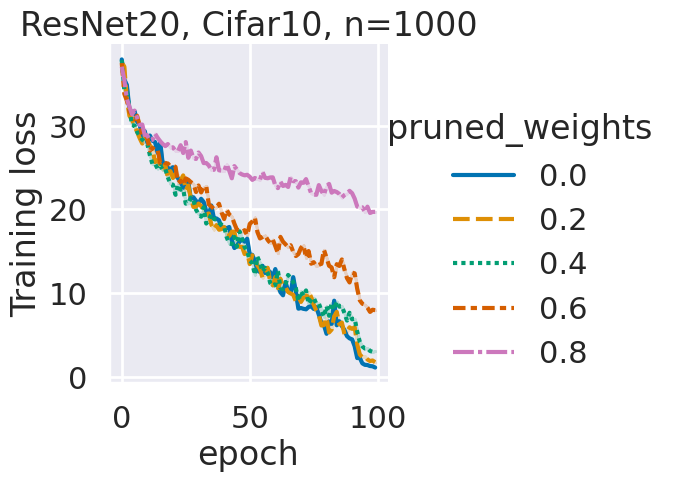

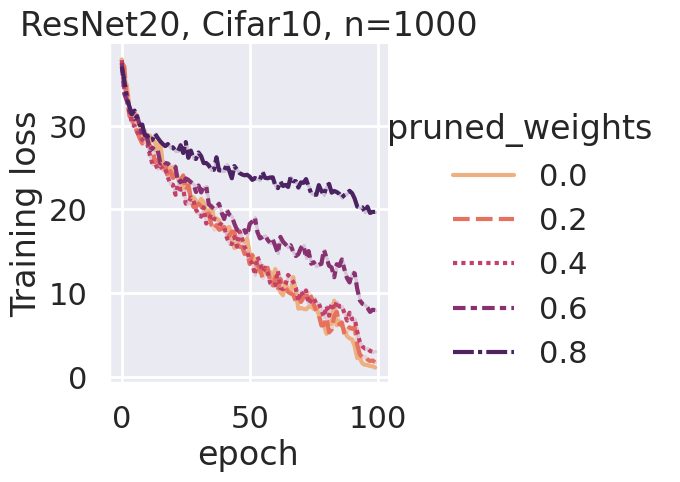

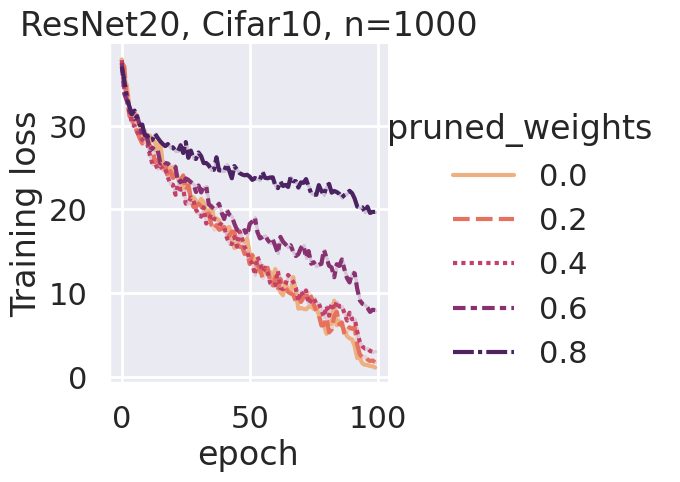

In [13]:
sns.relplot(pd.concat(training_infos), x='epoch', y='loss', hue='pruned_weights', style='pruned_weights', kind='line', palette='flare')

plt.ylabel('Training loss')
plt.title('ResNet20, Cifar10, n=1000')
plt.show()
# plt.savefig('ResNet20_training_loss.pdf', bbox_inches='tight')

In [167]:
def calc_H_O(network,train_itr,device):
    '''
    Calculates the outer product Hessian of the loss via the Jacobian of the network w.r.t. the parameters
    Returns: the Jacobian times its transposed averaged over all datapoints, and its non-zero spectrum
    
    network: Neural network
    x: input samples
    '''
    
    print('Calculating H_O...')
    
        
    start_tt = time.time()
    i = 0

    for b in train_itr:
    #     print(compute_jacobian(model_orig,b[0].unsqueeze(0)).shape)
        dim_0 = b[0].shape[0]*10

        b = b[0].to(torch.device(device))
        print(b.device)
        start_t = time.time()
    #         print(x[i,:].shape)
        if i==0:
            jacob = compute_jacobian(network,b).detach().view(dim_0,-1)
        else:
            jacob = torch.concatenate((jacob, 
                                       compute_jacobian(network,b).detach().view(dim_0,-1)), axis=0)
        print('i:', time.time() - start_t)
        # print(i,jacob.shape)

        i+=1
        
    jjT = jacob @ jacob.T
    
    print('jjT.shape=',jjT.shape)
    if jjT.shape[0] > 15000:
        print('Something is probably wrong!!')
        

    print('total time:', time.time() - start_tt)
    
    
#     jac_jac_T_rank = torch.linalg.matrix_rank(jac_jac_T, atol=1e-7/jac_jac_T.shape[0])
    # jac_jac_T_rank = torch.linalg.matrix_rank(jac_jac_T, atol=1e-7/jac_jac_T.shape[0])
    try:
        jac_jac_T_spectrum = torch.linalg.eigvalsh(jjT) #[-jac_jac_T_rank:]
    except:
        eps = 1e-19
        jac_jac_T_spectrum = torch.linalg.eigvalsh(jjT + eps*torch.eye(jjT.shape[0], device=torch.device(xdevice)))
        
    jac_T_jac_spectrum, _ = torch.sort(torch.abs(jac_jac_T_spectrum))

#     jac_jac_T = jac_jac_T
    
    print('Finished calculating H_O and spectrum ...')
    
    
    return jjT, jac_jac_T_spectrum

In [204]:
pruned_weights = [0.0, 0.2, 0.4, 0.6, 0.8]
epoch = 99

dfs = []
for p_w in pruned_weights:
    fn = f'panda_dataframes/outer_prod_hessian_information_ResNet20_pruned_weights={p_w}_{epoch}.pkl'

    df = load_pandas_df(fn)

    df = df.astype({'H_o_cond': float, 'H_o_rank': int, 'lambda_max_H_o': float, 'lambda_min_H_o': float})

    dfs.append(df)

hession_info_resnet20 = pd.concat(dfs,ignore_index=True)
hession_info_resnet20

,dataset,num_samples,network,pruned_weights,epoch,H_o_cond,H_o_spectrum,H_o_rank,lambda_max_H_o,lambda_min_H_o
0,Cifar10,1000,ResNet20,0.0,0,838.737305,"[tensor(20.8673), tensor(20.8825), tensor(21.9...",3061,2.202430e+05,2.625887e+02
1,Cifar10,1000,ResNet20,0.0,20,835.372375,"[tensor(-0.0025), tensor(-5.5507e-05), tensor(...",729,4.393573e+04,5.259418e+01
2,Cifar10,1000,ResNet20,0.0,40,838.282715,"[tensor(0.0090), tensor(0.0104), tensor(0.0104...",1377,6.154643e+04,7.341965e+01
3,Cifar10,1000,ResNet20,0.0,60,838.633240,"[tensor(0.0175), tensor(0.0200), tensor(0.0213...",2459,8.060548e+04,9.611529e+01
4,Cifar10,1000,ResNet20,0.0,80,838.763733,"[tensor(0.0361), tensor(0.0366), tensor(0.0383...",4020,9.535863e+04,1.136895e+02
5,Cifar10,1000,ResNet20,0.0,99,838.838074,"[tensor(0.0370), tensor(0.0459), tensor(0.0486...",4939,9.379543e+04,1.118159e+02
6,Cifar10,1000,ResNet20,0.2,0,838.388672,"[tensor(8.4253), tensor(8.6083), tensor(9.2854...",2696,1.677723e+05,2.001128e+02
7,Cifar10,1000,ResNet20,0.2,20,837.666382,"[tensor(0.0186), tensor(0.0223), tensor(0.0232...",715,7.381180e+04,8.811599e+01
8,Cifar10,1000,ResNet20,0.2,40,838.629517,"[tensor(0.1187), tensor(0.1352), tensor(0.1442...",1692,6.616649e+04,7.889836e+01
9,Cifar10,1000,ResNet20,0.2,60,838.432312,"[tensor(0.7575), tensor(0.7844), tensor(0.8237...",2674,1.131149e+05,1.349124e+02


In [205]:
for i in range(30):
    print(i)
    spec = hession_info_resnet20.loc[i].H_o_spectrum
    spec[spec < 0] = 0
    
    rank = torch.linalg.matrix_rank(torch.diag(spec), atol=1e-7)
    
    hession_info_resnet20.H_o_rank.loc[i] = int(rank)
    hession_info_resnet20.lambda_min_H_o.loc[i] = float(test[-rank])
    
    
    hession_info_resnet20.H_o_cond.loc[i] = hession_info_resnet20.loc[i].lambda_max_H_o/float(test[-rank])

0


/tmp/ipykernel_3384063/2921894560.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_rank.loc[i] = int(rank)
/tmp/ipykernel_3384063/2921894560.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.lambda_min_H_o.loc[i] = float(test[-rank])
/tmp/ipykernel_3384063/2921894560.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_cond.loc[i] = hession_info_resnet20.loc

1


/tmp/ipykernel_3384063/2921894560.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_rank.loc[i] = int(rank)
/tmp/ipykernel_3384063/2921894560.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.lambda_min_H_o.loc[i] = float(test[-rank])
/tmp/ipykernel_3384063/2921894560.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_cond.loc[i] = hession_info_resnet20.loc

2


/tmp/ipykernel_3384063/2921894560.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_rank.loc[i] = int(rank)
/tmp/ipykernel_3384063/2921894560.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.lambda_min_H_o.loc[i] = float(test[-rank])
/tmp/ipykernel_3384063/2921894560.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_cond.loc[i] = hession_info_resnet20.loc

3


/tmp/ipykernel_3384063/2921894560.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_rank.loc[i] = int(rank)
/tmp/ipykernel_3384063/2921894560.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.lambda_min_H_o.loc[i] = float(test[-rank])
/tmp/ipykernel_3384063/2921894560.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_cond.loc[i] = hession_info_resnet20.loc

4


/tmp/ipykernel_3384063/2921894560.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_rank.loc[i] = int(rank)
/tmp/ipykernel_3384063/2921894560.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.lambda_min_H_o.loc[i] = float(test[-rank])
/tmp/ipykernel_3384063/2921894560.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_cond.loc[i] = hession_info_resnet20.loc

5


/tmp/ipykernel_3384063/2921894560.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_rank.loc[i] = int(rank)
/tmp/ipykernel_3384063/2921894560.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.lambda_min_H_o.loc[i] = float(test[-rank])
/tmp/ipykernel_3384063/2921894560.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_cond.loc[i] = hession_info_resnet20.loc

6


/tmp/ipykernel_3384063/2921894560.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_rank.loc[i] = int(rank)
/tmp/ipykernel_3384063/2921894560.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.lambda_min_H_o.loc[i] = float(test[-rank])
/tmp/ipykernel_3384063/2921894560.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_cond.loc[i] = hession_info_resnet20.loc

7


/tmp/ipykernel_3384063/2921894560.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_rank.loc[i] = int(rank)
/tmp/ipykernel_3384063/2921894560.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.lambda_min_H_o.loc[i] = float(test[-rank])
/tmp/ipykernel_3384063/2921894560.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_cond.loc[i] = hession_info_resnet20.loc

8


/tmp/ipykernel_3384063/2921894560.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_rank.loc[i] = int(rank)
/tmp/ipykernel_3384063/2921894560.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.lambda_min_H_o.loc[i] = float(test[-rank])
/tmp/ipykernel_3384063/2921894560.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_cond.loc[i] = hession_info_resnet20.loc

9


/tmp/ipykernel_3384063/2921894560.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_rank.loc[i] = int(rank)
/tmp/ipykernel_3384063/2921894560.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.lambda_min_H_o.loc[i] = float(test[-rank])
/tmp/ipykernel_3384063/2921894560.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_cond.loc[i] = hession_info_resnet20.loc

10


/tmp/ipykernel_3384063/2921894560.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_rank.loc[i] = int(rank)
/tmp/ipykernel_3384063/2921894560.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.lambda_min_H_o.loc[i] = float(test[-rank])
/tmp/ipykernel_3384063/2921894560.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_cond.loc[i] = hession_info_resnet20.loc

11


/tmp/ipykernel_3384063/2921894560.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_rank.loc[i] = int(rank)
/tmp/ipykernel_3384063/2921894560.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.lambda_min_H_o.loc[i] = float(test[-rank])
/tmp/ipykernel_3384063/2921894560.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_cond.loc[i] = hession_info_resnet20.loc

12


/tmp/ipykernel_3384063/2921894560.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_rank.loc[i] = int(rank)
/tmp/ipykernel_3384063/2921894560.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.lambda_min_H_o.loc[i] = float(test[-rank])
/tmp/ipykernel_3384063/2921894560.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_cond.loc[i] = hession_info_resnet20.loc

13


/tmp/ipykernel_3384063/2921894560.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_rank.loc[i] = int(rank)
/tmp/ipykernel_3384063/2921894560.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.lambda_min_H_o.loc[i] = float(test[-rank])
/tmp/ipykernel_3384063/2921894560.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_cond.loc[i] = hession_info_resnet20.loc

14


/tmp/ipykernel_3384063/2921894560.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_rank.loc[i] = int(rank)
/tmp/ipykernel_3384063/2921894560.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.lambda_min_H_o.loc[i] = float(test[-rank])
/tmp/ipykernel_3384063/2921894560.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_cond.loc[i] = hession_info_resnet20.loc

15


/tmp/ipykernel_3384063/2921894560.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_rank.loc[i] = int(rank)
/tmp/ipykernel_3384063/2921894560.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.lambda_min_H_o.loc[i] = float(test[-rank])
/tmp/ipykernel_3384063/2921894560.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_cond.loc[i] = hession_info_resnet20.loc

16


/tmp/ipykernel_3384063/2921894560.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_rank.loc[i] = int(rank)
/tmp/ipykernel_3384063/2921894560.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.lambda_min_H_o.loc[i] = float(test[-rank])
/tmp/ipykernel_3384063/2921894560.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_cond.loc[i] = hession_info_resnet20.loc

17


/tmp/ipykernel_3384063/2921894560.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_rank.loc[i] = int(rank)
/tmp/ipykernel_3384063/2921894560.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.lambda_min_H_o.loc[i] = float(test[-rank])
/tmp/ipykernel_3384063/2921894560.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_cond.loc[i] = hession_info_resnet20.loc

18


/tmp/ipykernel_3384063/2921894560.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_rank.loc[i] = int(rank)
/tmp/ipykernel_3384063/2921894560.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.lambda_min_H_o.loc[i] = float(test[-rank])
/tmp/ipykernel_3384063/2921894560.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_cond.loc[i] = hession_info_resnet20.loc

19


/tmp/ipykernel_3384063/2921894560.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_rank.loc[i] = int(rank)
/tmp/ipykernel_3384063/2921894560.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.lambda_min_H_o.loc[i] = float(test[-rank])
/tmp/ipykernel_3384063/2921894560.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_cond.loc[i] = hession_info_resnet20.loc

20


/tmp/ipykernel_3384063/2921894560.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_rank.loc[i] = int(rank)
/tmp/ipykernel_3384063/2921894560.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.lambda_min_H_o.loc[i] = float(test[-rank])
/tmp/ipykernel_3384063/2921894560.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_cond.loc[i] = hession_info_resnet20.loc

21


/tmp/ipykernel_3384063/2921894560.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_rank.loc[i] = int(rank)
/tmp/ipykernel_3384063/2921894560.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.lambda_min_H_o.loc[i] = float(test[-rank])
/tmp/ipykernel_3384063/2921894560.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_cond.loc[i] = hession_info_resnet20.loc

22


/tmp/ipykernel_3384063/2921894560.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_rank.loc[i] = int(rank)
/tmp/ipykernel_3384063/2921894560.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.lambda_min_H_o.loc[i] = float(test[-rank])
/tmp/ipykernel_3384063/2921894560.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_cond.loc[i] = hession_info_resnet20.loc

23


/tmp/ipykernel_3384063/2921894560.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_rank.loc[i] = int(rank)
/tmp/ipykernel_3384063/2921894560.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.lambda_min_H_o.loc[i] = float(test[-rank])
/tmp/ipykernel_3384063/2921894560.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_cond.loc[i] = hession_info_resnet20.loc

24


/tmp/ipykernel_3384063/2921894560.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_rank.loc[i] = int(rank)
/tmp/ipykernel_3384063/2921894560.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.lambda_min_H_o.loc[i] = float(test[-rank])
/tmp/ipykernel_3384063/2921894560.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_cond.loc[i] = hession_info_resnet20.loc

25


/tmp/ipykernel_3384063/2921894560.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_rank.loc[i] = int(rank)
/tmp/ipykernel_3384063/2921894560.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.lambda_min_H_o.loc[i] = float(test[-rank])
/tmp/ipykernel_3384063/2921894560.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_cond.loc[i] = hession_info_resnet20.loc

26


/tmp/ipykernel_3384063/2921894560.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_rank.loc[i] = int(rank)
/tmp/ipykernel_3384063/2921894560.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.lambda_min_H_o.loc[i] = float(test[-rank])
/tmp/ipykernel_3384063/2921894560.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_cond.loc[i] = hession_info_resnet20.loc

27


/tmp/ipykernel_3384063/2921894560.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_rank.loc[i] = int(rank)
/tmp/ipykernel_3384063/2921894560.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.lambda_min_H_o.loc[i] = float(test[-rank])
/tmp/ipykernel_3384063/2921894560.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_cond.loc[i] = hession_info_resnet20.loc

28


/tmp/ipykernel_3384063/2921894560.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_rank.loc[i] = int(rank)
/tmp/ipykernel_3384063/2921894560.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.lambda_min_H_o.loc[i] = float(test[-rank])
/tmp/ipykernel_3384063/2921894560.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_cond.loc[i] = hession_info_resnet20.loc

29


/tmp/ipykernel_3384063/2921894560.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_rank.loc[i] = int(rank)
/tmp/ipykernel_3384063/2921894560.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.lambda_min_H_o.loc[i] = float(test[-rank])
/tmp/ipykernel_3384063/2921894560.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hession_info_resnet20.H_o_cond.loc[i] = hession_info_resnet20.loc

In [207]:
hession_info_resnet20.to_pickle(f"panda_dataframes/outer_prod_hessian_information_ResNet20_pruned_weights.pkl")


In [162]:
sns.set_theme()
sns.set_context("talk")

def plot_hessian_info(df,y):
    
    sns.relplot(hession_info_resnet20, x='epoch', y=y, hue='pruned_weights', style='pruned_weights', markers=True, kind='line', palette='colorblind')
    


/users/staff/dmi-dmi/zhao0005/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


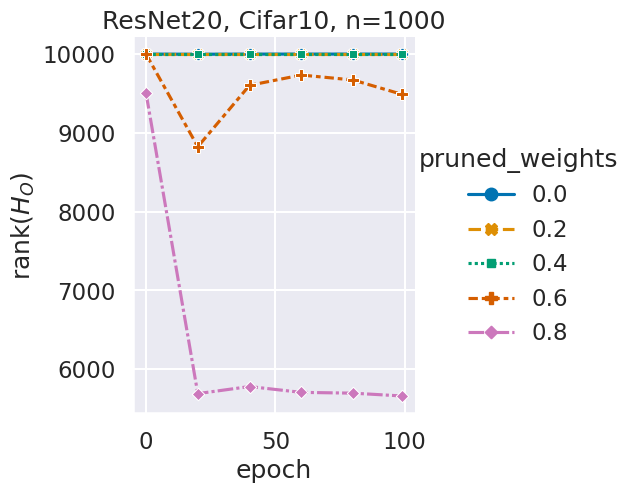

In [174]:
plot_hessian_info(df,'H_o_rank')
plt.ylabel('rank$(H_O)$')

plt.title('ResNet20, Cifar10, n=1000')
plt.savefig('ResNet20_rank_HO.pdf', bbox_inches='tight')

/users/staff/dmi-dmi/zhao0005/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


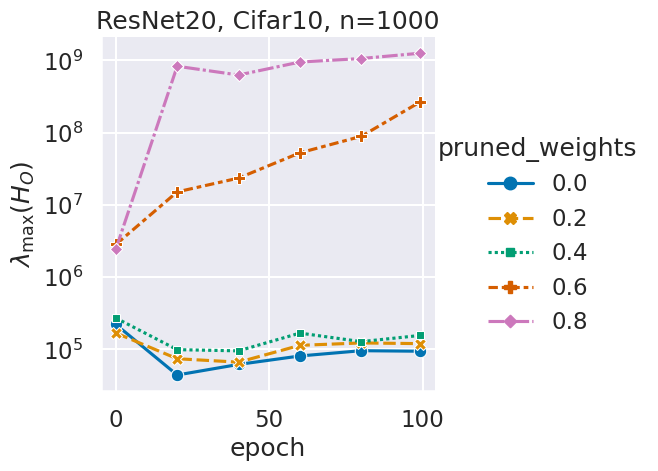

In [180]:
plot_hessian_info(df,'lambda_max_H_o')
plt.yscale('log')
plt.ylabel('$\lambda_{\max}(H_O)$')

plt.title('ResNet20, Cifar10, n=1000')
plt.savefig('ResNet20_lam_max_HO.pdf', bbox_inches='tight')

/users/staff/dmi-dmi/zhao0005/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


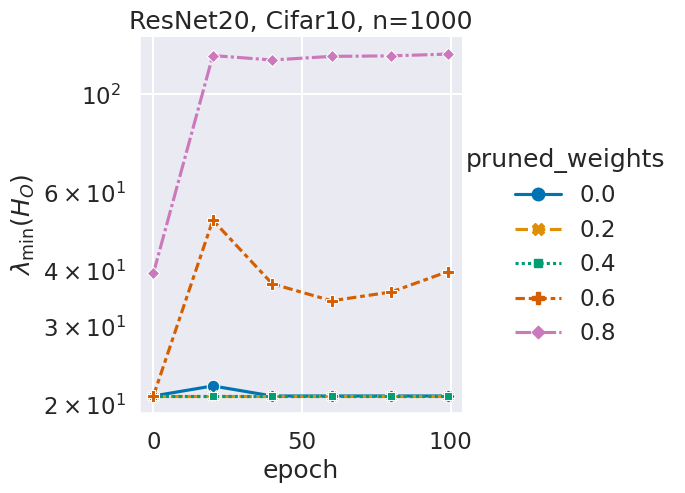

In [179]:
plot_hessian_info(df,'lambda_min_H_o')
plt.yscale('log')
plt.ylabel('$\lambda_{\min}(H_O)$')

plt.title('ResNet20, Cifar10, n=1000')
plt.savefig('ResNet20_lam_min_HO.pdf', bbox_inches='tight')

/users/staff/dmi-dmi/zhao0005/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


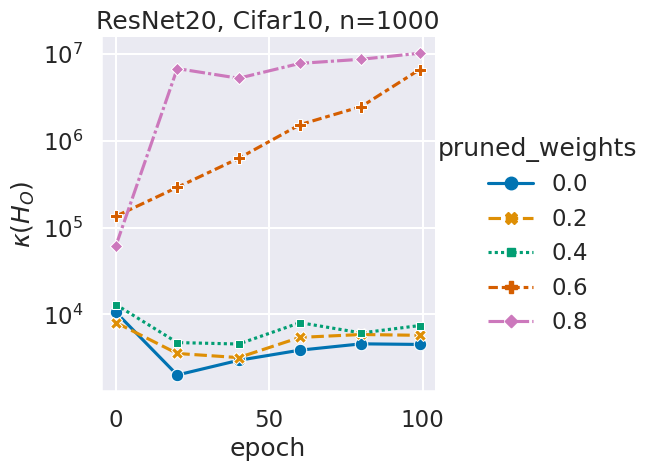

In [178]:
plot_hessian_info(df,'H_o_cond')
plt.yscale('log')
plt.ylabel('$\kappa(H_O)$')

plt.title('ResNet20, Cifar10, n=1000')
plt.savefig('ResNet20_cond_HO.pdf', bbox_inches='tight')

In [186]:
np.log(sum((hession_info_resnet20[hession_info_resnet20['pruned_weights'] == 0.0].H_o_cond)))

10.255186539516734

In [187]:
np.log(sum((hession_info_resnet20[hession_info_resnet20['pruned_weights'] == 0.2].H_o_cond)))

10.36555738534702

In [188]:
np.log(sum((hession_info_resnet20[hession_info_resnet20['pruned_weights'] == 0.4].H_o_cond)))

10.686323169033766

In [189]:
np.log(sum((hession_info_resnet20[hession_info_resnet20['pruned_weights'] == 0.6].H_o_cond)))

16.273534292888566

In [190]:
np.log(sum((hession_info_resnet20[hession_info_resnet20['pruned_weights'] == 0.8].H_o_cond)))

17.47366567514312

# train reset20


In [170]:
start_tt = time.time()
i = 0

for b in train_itr:
#     print(compute_jacobian(model_orig,b[0].unsqueeze(0)).shape)
    dim_0 = b[0].shape[0]*10

    b = b[0].to(torch.device('cuda:1'))
    start_t = time.time()
#         print(x[i,:].shape)
    if i==0:
        jacob = compute_jacobian(model_orig,b).detach().view(dim_0,-1)
    else:
        jacob = torch.concatenate((jacob, 
                                   compute_jacobian(model_orig,b).detach().view(dim_0,-1)), axis=0)
    print('i:', time.time() - start_t)
    # print(i,jacob.shape)
    
    if i == 0:
        break
    
    i+=1

print('total time:', time.time() - start_tt)



98304
i: 9.096469640731812
total time: 9.794232368469238


In [168]:
jacob.shape

torch.Size([160, 136237])

In [72]:
%%time
import torch.nn.functional as F

torch.manual_seed(6666)
torch.cuda.manual_seed(6666)

model_orig = resnet20()

opt = optim.SGD(model_orig.parameters(), lr=1e-1, momentum=0.9, weight_decay=1e-4, nesterov=False)
loss_fn = F.cross_entropy

lr_scheduler= optim.lr_scheduler.MultiStepLR(opt, milestones=[91, 137], gamma=0.1)

history = main(model_orig, opt, epoch=100, model_name='ResNet20', pruned_weights=0.0, loss_fn=loss_fn, dev='cuda:0', lr_scheduler=lr_scheduler)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Setting up a new session...
Setting up a new session...


Setting up a new session...
Setting up a new session...
Setting up a new session...
Setting up a new session...


Epoch: 1/100, lr:1.00e-01
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.10it/s, loss:2.3498, acc:14.9000%]
Val loss: 9.9151, accuracy: 13.20%
Epoch: 2/100, lr:1.00e-01
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.21it/s, loss:2.2187, acc:18.0000%]
SAVING MODEL
Val loss: 5.2690, accuracy: 14.40%
Epoch: 3/100, lr:1.00e-01
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.35it/s, loss:2.1337, acc:20.0000%]
Val loss: 3.1000, accuracy: 19.20%
Epoch: 4/100, lr:1.00e-01
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.02it/s, loss:0.8251, acc:71.5000%]
SAVING MODEL
Val loss: 2.7364, accuracy: 36.40%
Epoch: 60/100, lr:1.00e-01
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.22it/s, loss:0.8280, acc:69.4000%]
Val loss: 2.8895, accuracy: 36.40%
Epoch: 61/100, lr:1.00e-01
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 15.32it/s, loss:0.7190, acc:74.8000%]
Val loss: 2.9719, accuracy: 39.20%
Epoch: 62/100, lr:1.00e-01
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|

# plot loss history
We check the classifier by plotting the loss and acc.

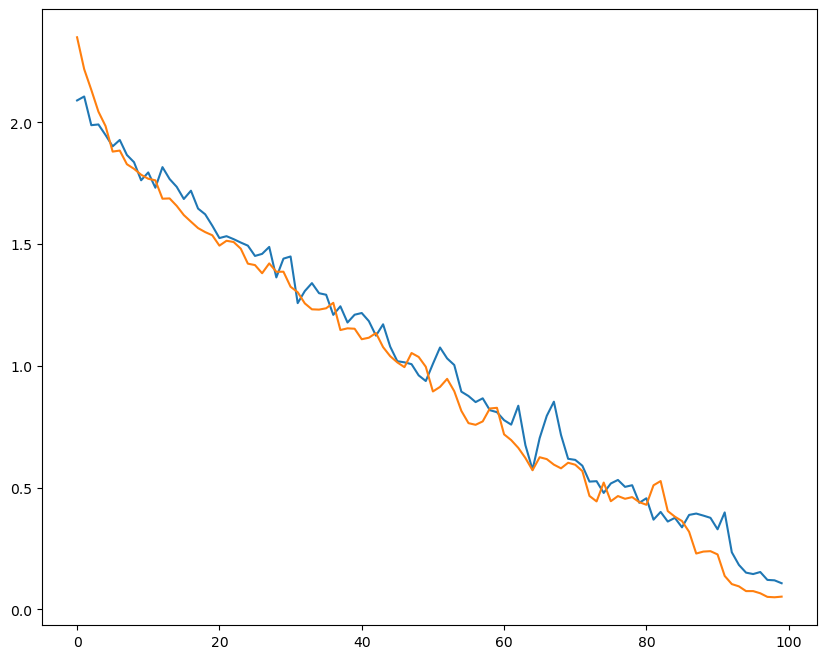

In [93]:
plt.plot(np.arange(len(train_info.loss[::16])),train_info.loss.iloc[::16]/16)
plt.plot(history['train_loss'])

In [237]:
model2 = resnet20()
dictionary = torch.load('checkpoint_epoch_99.pth')

print(dictionary['epoch'])
model2.load_state_dict(dictionary['model_state_dict'])
model2.eval()



FileNotFoundError: [Errno 2] No such file or directory: 'checkpoint_epoch_99.pth'

In [ ]:
x = torch.randn(1,3,32,32)

model2(x)

In [ ]:
engine = Engine()

In [ ]:
model2 = model2.to('cuda:0')

In [40]:
# def h(sample, device='cuda:0'):
#     x = sample[0].to(device)
#     y = sample[1].to(device)
#     o = model2(x)
#     return loss_fn(o, y), o

# meter_loss = tnt.meter.AverageValueMeter()
# classacc = tnt.meter.ClassErrorMeter(accuracy=True)

# data = CIFAR10Data(train_split=0.8)
# test_itr = data.get_test_loader(batch_size=64)
# engine.test(h, test_itr)